In [1]:
from __init__ import get_base_path
from dotenv import load_dotenv
from geopy.distance import geodesic
from google_api import get_address
from matplotlib import pyplot as plt
from math import ceil
import json
import numpy as np
import os
import pandas as pd
import seaborn as sns
import sys
import time
import warnings
warnings.filterwarnings('ignore')

# environment
load_dotenv(get_base_path() + '/airbnb.env')
api_key = os.getenv('GOOGLE_API_KEY')
data_dir = get_base_path() + os.getenv('data_dir')

# Load Airbnb data
path = data_dir + 'processed/' + 'airbnb_cleansed_sample_with_landmark_mta_features' + '.csv'
airbnb_data = pd.read_csv(path,index_col=0)


/Users/kmazurczyk/Desktop/AirBnB-Price-Predictor/airbnbenv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# Google API ETL

In [2]:
airbnb_lat_long = airbnb_data[['id','latitude','longitude']].copy()
airbnb_lat_long.shape

(25000, 3)

In [3]:
# results from earlier API call were stored
result = pd.DataFrame()

# collect
for root, dirs, files in os.walk(data_dir + 'raw/'):
    for file in files:
        if 'zipcode_response_batch' in file:
            temp_df = pd.read_csv(root+file, index_col = 0, low_memory = False)
            result = pd.concat([result, temp_df])

result.shape

(25000, 3)

In [4]:
%%script false --no-raise-error

'''
transforms data and calls Google Geocoder API for address info based on latitude / longitude
returns new dataframe containing raw response
this method saves partial progress to .csv in case of fatal error

a Google API run of 25,000 records is expected to take ~10 minutes at a minimum (max API quota 3000 req/min)
based on timed tests, dict iteration was exponentially faster than either iterrows or df.apply and concatenating dfs
so each batch is transformed to dict before saving back up to df
'''

# batch dataframe to be consumable for API
df_length = airbnb_lat_long.shape[0]
hist, bin_edges = np.histogram(range(0,df_length+1),bins=50)
slices = [ceil(i) for i in bin_edges]
dfs = [airbnb_lat_long.iloc[slices[i-1]:slices[i]].copy() for i in range(len(slices)) if i > 0]

# transform each batch as a dictionary
dictionary = dict()
for index, df in enumerate(dfs):
    
    time.sleep(1)
    keys = df['id'].to_list()
    this_dictionary = dict()

    for key in keys:
        this_dictionary[key] = df.loc[df['id'] == key,['latitude','longitude']].to_dict(orient='split')['data'][0]
        try:
            latitude = this_dictionary[key][0]
            longitude = this_dictionary[key][1]
            response = get_address(latitude, longitude, api_key)
            this_dictionary[key] = [latitude,longitude, response]
        except IndexError: # if there is no lat/long, then continue
            continue    

    # materialize partial progress in case API fails
    this_df = pd.DataFrame.from_dict(this_dictionary,orient='index',columns=['latitude','longitude','response'])
    path = data_dir + "raw/" + f"zipcode_response_batch{index}" + ".csv"
    this_df.to_csv(path)
    
    # append results
    dictionary = dictionary | this_dictionary
    print(f"slice {index} processed")

result = pd.DataFrame.from_dict(dictionary,orient='index',columns=['latitude','longitude','response'])

In [5]:
# Function to extract individual address components from Google API response get_address()
def get_address_component(dict, component):

    try:
        result = [item['long_name'] for item in dict['address_components'] if item['types'] == ['postal_code']]
        if len(result) > 0:
            return result[0]
        else:
            return None
    except Exception as e:
        # print(e)
        return None

In [6]:
# if we have read from csv, we have to transform str to dict
# in the json there are actual quotes that are part of the text, and others that denote fields
actual_quotes = r'(?<=[a-zA-Z0-9])[\'"](?=[a-zA-Z0-9])'
result['cleaned'] = result['response'].fillna('').str.replace("\'",'\"').str.replace(actual_quotes,'',regex=True).apply(lambda x: json.loads(x) if x != '' else '')

Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/asyncio/unix_events.py", line 665, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe


In [7]:
# extract and clean the zipcode
result['zip_code'] = result['cleaned'].apply(lambda x: get_address_component(x,'postal_code'))
result['zip_code'] = result['zip_code'].fillna('').apply(lambda x: x[0:5] if len(x) > 5 else x)
result.head()


,latitude,longitude,response,cleaned,zip_code
811578932102642774,40.671477,-73.938889,{'address_components': [{'long_name': '259-261...,{'address_components': [{'long_name': '259-261...,11213
6626581,40.726990,-73.986940,"{'address_components': [{'long_name': '333', '...","{'address_components': [{'long_name': '333', '...",10003
4440181,40.690140,-73.959400,"{'address_components': [{'long_name': '448', '...","{'address_components': [{'long_name': '448', '...",11205
12810210,40.717950,-73.954220,"{'address_components': [{'long_name': '219', '...","{'address_components': [{'long_name': '219', '...",11211
672347600157032155,40.641694,-73.938663,"{'address_components': [{'long_name': '561', '...","{'address_components': [{'long_name': '561', '...",11203


In [8]:
result.isna().sum()

latitude        0
longitude       0
response     2212
cleaned         0
zip_code        0
dtype: int64

In [9]:
airbnb_data

,id,last_scraped,latitude,longitude,accommodates,bedrooms,price,minimum_nights,instant_bookable,calculated_host_listings_count_entire_homes,...,times_square_log_dist,wall_street_log_dist,whitney_museum_log_dist,yankee_stadium_log_dist,mean_dist_landmarks,median_dist_landmarks,num_landmarks_dist_500m,closest_landmark,mean_log_dist_landmarks,median_log_dist_landmarks
7347,42273545,2024-09-04,40.660070,-73.953720,1,0.0,70.0,30,0,0,...,9.323650,8.840677,9.208807,9.850827,11331.291651,10890.319346,0,brooklyn_museum,9.253238,9.295433
15309,1148821271649296263,2024-09-05,40.766013,-73.987527,4,0.0,450.0,3,0,1,...,6.811474,8.839301,8.144248,9.077949,4590.925856,2504.645152,0,carnegie_hall,7.974258,7.825830
23466,886759118206964183,2024-09-05,40.754659,-73.972129,2,1.0,455.0,31,1,876,...,7.082553,8.736665,8.167639,9.125425,4361.771176,2596.555524,2,grand_central_station,7.850669,7.857079
185769,713666857948299920,2024-05-04,40.762940,-73.958950,6,2.0,214.0,30,1,1,...,7.745939,8.935343,8.506943,8.975494,4904.414800,2548.875090,0,central_park_zoo,8.181458,7.839575
32391,13386091,2024-09-05,40.614280,-74.006180,6,2.0,175.0,30,0,1,...,9.683593,9.229216,9.540865,10.120717,15805.852933,15847.384793,0,coney_island,9.610687,9.670676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24093,13170159,2024-09-05,40.580190,-73.954200,4,1.0,140.0,30,0,2,...,9.899461,9.596810,9.814347,10.232875,19281.843593,19628.321105,0,coney_island,9.784656,9.884633
29082,24021046,2024-09-05,40.586002,-73.813883,2,1.0,65.0,30,0,1,...,10.085248,9.961849,10.074159,10.263664,23491.316626,23737.559437,0,coney_island,10.052646,10.074814
1445,14672524,2024-09-05,40.799810,-73.948040,3,1.0,105.0,30,0,0,...,8.634425,9.359707,9.039758,8.240630,7170.490952,5766.690948,0,apollo_theater,8.670603,8.659790
259246,812492800852380445,2024-03-08,40.751067,-73.984676,4,2.0,225.0,1,1,30,...,6.647139,8.594492,7.786508,9.212932,4343.337780,2393.070184,2,empire_state_building,7.820574,7.780313


In [10]:
airbnb_data = airbnb_data.set_index('id').join(result['zip_code'])
airbnb_data.head()

,last_scraped,latitude,longitude,accommodates,bedrooms,price,minimum_nights,instant_bookable,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,...,wall_street_log_dist,whitney_museum_log_dist,yankee_stadium_log_dist,mean_dist_landmarks,median_dist_landmarks,num_landmarks_dist_500m,closest_landmark,mean_log_dist_landmarks,median_log_dist_landmarks,zip_code
id,,,,,,,,,,,,,,,,,,,,,
42273545,2024-09-04,40.660070,-73.953720,1,0.0,70.0,30,0,0,1,...,8.840677,9.208807,9.850827,11331.291651,10890.319346,0,brooklyn_museum,9.253238,9.295433,11225
1148821271649296263,2024-09-05,40.766013,-73.987527,4,0.0,450.0,3,0,1,0,...,8.839301,8.144248,9.077949,4590.925856,2504.645152,0,carnegie_hall,7.974258,7.825830,10019
886759118206964183,2024-09-05,40.754659,-73.972129,2,1.0,455.0,31,1,876,0,...,8.736665,8.167639,9.125425,4361.771176,2596.555524,2,grand_central_station,7.850669,7.857079,10017
713666857948299920,2024-05-04,40.762940,-73.958950,6,2.0,214.0,30,1,1,0,...,8.935343,8.506943,8.975494,4904.414800,2548.875090,0,central_park_zoo,8.181458,7.839575,10065
13386091,2024-09-05,40.614280,-74.006180,6,2.0,175.0,30,0,1,0,...,9.229216,9.540865,10.120717,15805.852933,15847.384793,0,coney_island,9.610687,9.670676,11228


# Save to CSV

In [ ]:
path = data_dir + "processed/" + f"airbnb_sample_landmarks_mta_zipcodes" + ".csv"
airbnb_data.to_csv(path)

# EDA

In [12]:
airbnb_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25000 entries, 42273545 to 46923174
Data columns (total 92 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   last_scraped                                  25000 non-null  object 
 1   latitude                                      25000 non-null  float64
 2   longitude                                     25000 non-null  float64
 3   accommodates                                  25000 non-null  int64  
 4   bedrooms                                      25000 non-null  float64
 5   price                                         25000 non-null  float64
 6   minimum_nights                                25000 non-null  int64  
 7   instant_bookable                              25000 non-null  int64  
 8   calculated_host_listings_count_entire_homes   25000 non-null  int64  
 9   calculated_host_listings_count_private_rooms  25000 non-

In [13]:
airbnb_data['zip_code'].nunique()

231

In [14]:
airbnb_data.describe().T

,count,mean,std,min,25%,50%,75%,max
latitude,25000.0,40.730433,0.052226,40.566490,40.691240,40.729775,40.762964,40.902260
longitude,25000.0,-73.956917,0.043247,-74.168440,-73.986294,-73.961750,-73.941635,-73.715477
accommodates,25000.0,2.950120,2.156436,1.000000,2.000000,2.000000,4.000000,16.000000
bedrooms,25000.0,1.622560,1.086088,0.000000,1.000000,1.000000,2.000000,42.000000
price,25000.0,219.354200,420.591777,10.000000,91.000000,160.000000,214.000000,30000.000000
...,...,...,...,...,...,...,...,...
mean_dist_landmarks,25000.0,8021.752758,3548.634795,4219.850576,5275.995726,7067.213546,9772.866665,26389.014282
median_dist_landmarks,25000.0,6811.376481,4119.726913,2204.918102,3528.762084,5802.844629,9150.333967,26696.115321
num_landmarks_dist_500m,25000.0,0.254160,0.713571,0.000000,0.000000,0.000000,0.000000,6.000000
mean_log_dist_landmarks,25000.0,8.704174,0.534813,7.561219,8.304335,8.686005,9.108828,10.175978


In [15]:
# data prep for EDA
airbnb_data['log_price'] = np.log(airbnb_data['price'])

In [16]:
def quantile_25(x):
    return np.quantile(x,0.25)

def quantile_75(x):
    return np.quantile(x,0.75)

pivot = pd.pivot_table(
    airbnb_data,
    values=['log_price'],
    index=['zip_code'],
    aggfunc=['count','mean','median',np.var,'min',quantile_25,quantile_75,'max']
)

pivot.sort_values(('count','log_price'),ascending=False).head(50)

,count,mean,median,var,min,quantile_25,quantile_75,max
,log_price,log_price,log_price,log_price,log_price,log_price,log_price,log_price
zip_code,,,,,,,,
,2212,4.920581,4.941642,0.482534,2.995732,4.369448,5.365976,8.517193
10036,1045,5.376492,5.365976,0.516593,3.713572,4.700480,5.860786,7.775276
10019,945,5.530199,5.365976,0.576214,3.737670,5.043425,5.958425,9.210340
11221,839,4.512064,4.248495,0.411978,3.178054,4.094345,5.075174,7.312553
10016,707,5.393828,5.365976,0.466211,3.555348,4.941642,5.853629,8.517193
11211,695,4.937812,5.164786,0.355229,2.302585,4.248495,5.164786,6.906755
10002,643,5.294044,5.365976,0.557172,3.663562,4.653960,5.625819,9.053687
10001,631,5.370376,5.365976,0.503409,3.637586,4.653960,5.853629,9.210240


[Text(0, 0, ''),
 Text(1, 0, '02558'),
 Text(2, 0, '04950'),
 Text(3, 0, '06117'),
 Text(4, 0, '07030'),
 Text(5, 0, '07093'),
 Text(6, 0, '08031'),
 Text(7, 0, '10001'),
 Text(8, 0, '10002'),
 Text(9, 0, '10003'),
 Text(10, 0, '10004'),
 Text(11, 0, '10005'),
 Text(12, 0, '10006'),
 Text(13, 0, '10007'),
 Text(14, 0, '10009'),
 Text(15, 0, '10010'),
 Text(16, 0, '10011'),
 Text(17, 0, '10012'),
 Text(18, 0, '10013'),
 Text(19, 0, '10014'),
 Text(20, 0, '10016'),
 Text(21, 0, '10017'),
 Text(22, 0, '10018'),
 Text(23, 0, '10019'),
 Text(24, 0, '10020'),
 Text(25, 0, '10021'),
 Text(26, 0, '10022'),
 Text(27, 0, '10023'),
 Text(28, 0, '10024'),
 Text(29, 0, '10025'),
 Text(30, 0, '10026'),
 Text(31, 0, '10027'),
 Text(32, 0, '10028'),
 Text(33, 0, '10029'),
 Text(34, 0, '10030'),
 Text(35, 0, '10031'),
 Text(36, 0, '10032'),
 Text(37, 0, '10033'),
 Text(38, 0, '10034'),
 Text(39, 0, '10035'),
 Text(40, 0, '10036'),
 Text(41, 0, '10037'),
 Text(42, 0, '10038'),
 Text(43, 0, '10039'),
 Te

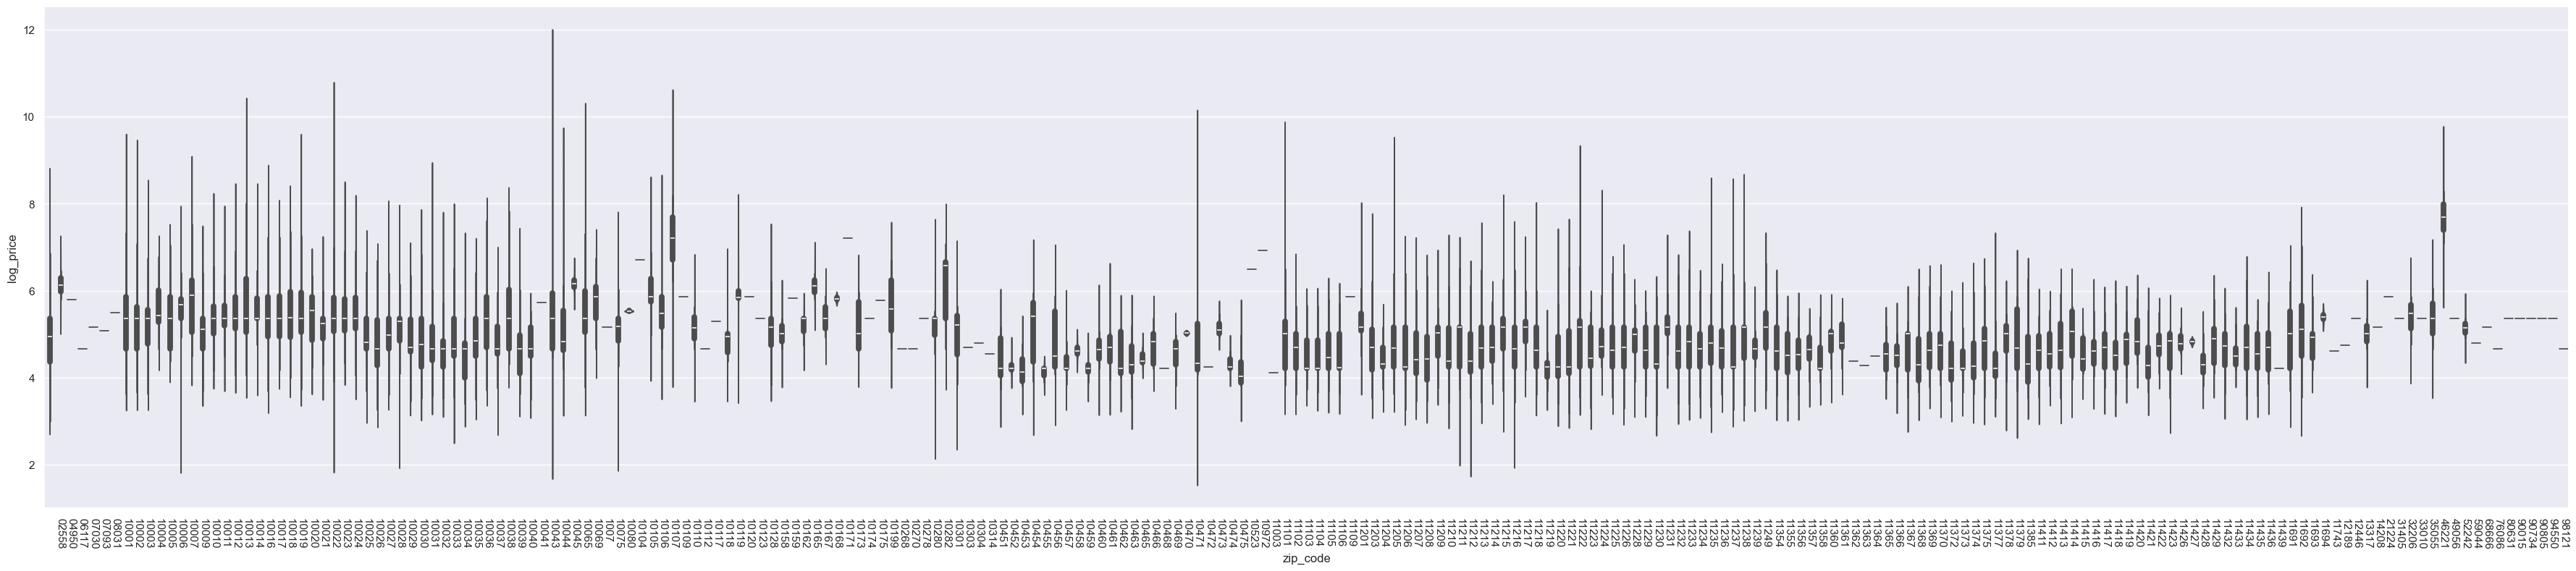

In [17]:
#frequency visualization essentially useless for such high cardinality
airbnb_data.sort_values('zip_code',inplace=True)
sns.set_theme(rc={'figure.figsize':(45,9)})
g = sns.violinplot(airbnb_data, x='zip_code',y='log_price')
g.set_xticklabels(labels = airbnb_data['zip_code'].unique(), rotation = -90)

<Axes: xlabel='zip_code', ylabel='Count'>

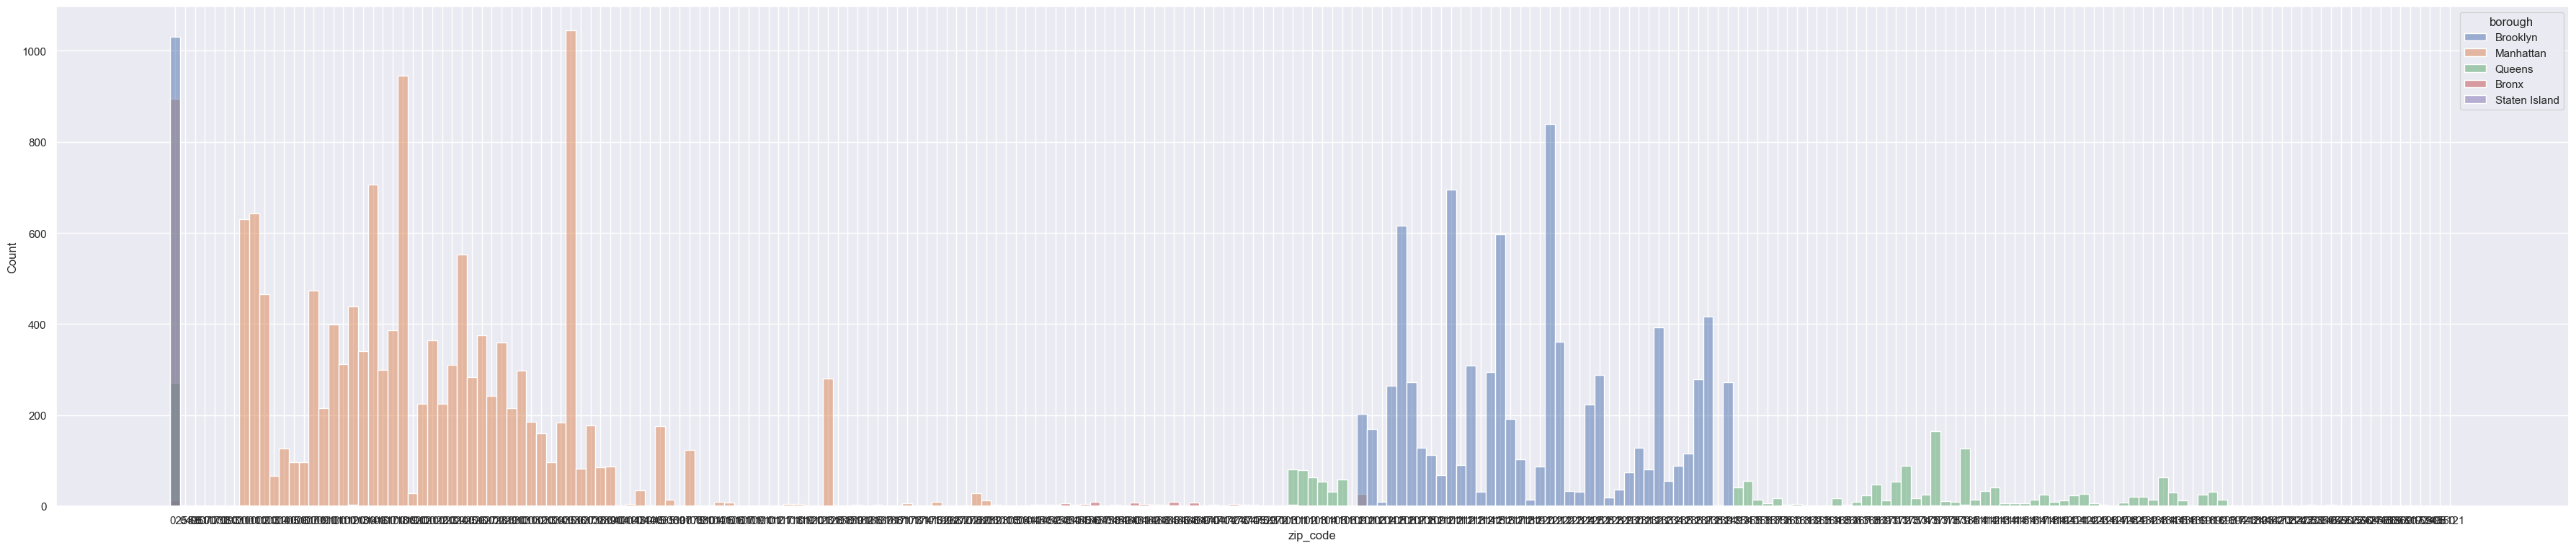

In [18]:
%matplotlib inline
sns.histplot(airbnb_data, x='zip_code', hue='borough')

[Text(-5000.0, 0, ''),
 Text(0.0, 0, ''),
 Text(5000.0, 0, ''),
 Text(10000.0, 0, ''),
 Text(15000.0, 0, ''),
 Text(20000.0, 0, ''),
 Text(25000.0, 0, ''),
 Text(30000.0, 0, '')]

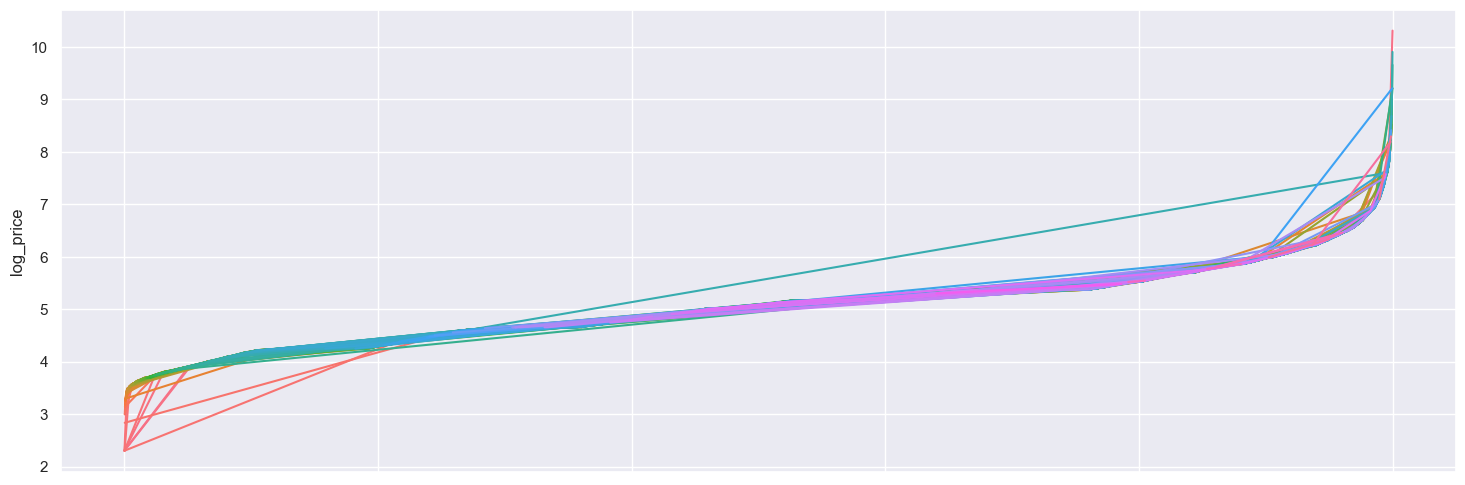

In [19]:
airbnb_data.sort_values('log_price',inplace=True)

sns.set_theme(rc={'figure.figsize':(18,6)})
len_df = airbnb_data.shape[0]
g = sns.lineplot(data=airbnb_data,x=range(len_df),y='log_price',hue='zip_code',legend=False)
g.set_xticklabels(labels = ['' for i in range(len_df)])

# Correlation

In [20]:
zip_code_price = airbnb_data[['zip_code','log_price']].copy()
zip_code_price = pd.get_dummies(zip_code_price)
corr_df = zip_code_price.corr()

print("Correlation of zipcode to log_price")
print(corr_df['log_price'].sort_values(ascending=False)[2:])

Correlation of zipcode to log_price
zip_code_10013    0.117436
zip_code_10036    0.095144
zip_code_10014    0.082352
zip_code_10016    0.081667
zip_code_10018    0.079556
                    ...   
zip_code_11207   -0.066621
zip_code_11377   -0.075122
zip_code_11216   -0.075943
zip_code_11206   -0.103098
zip_code_11221   -0.130474
Name: log_price, Length: 230, dtype: float64


<Axes: >

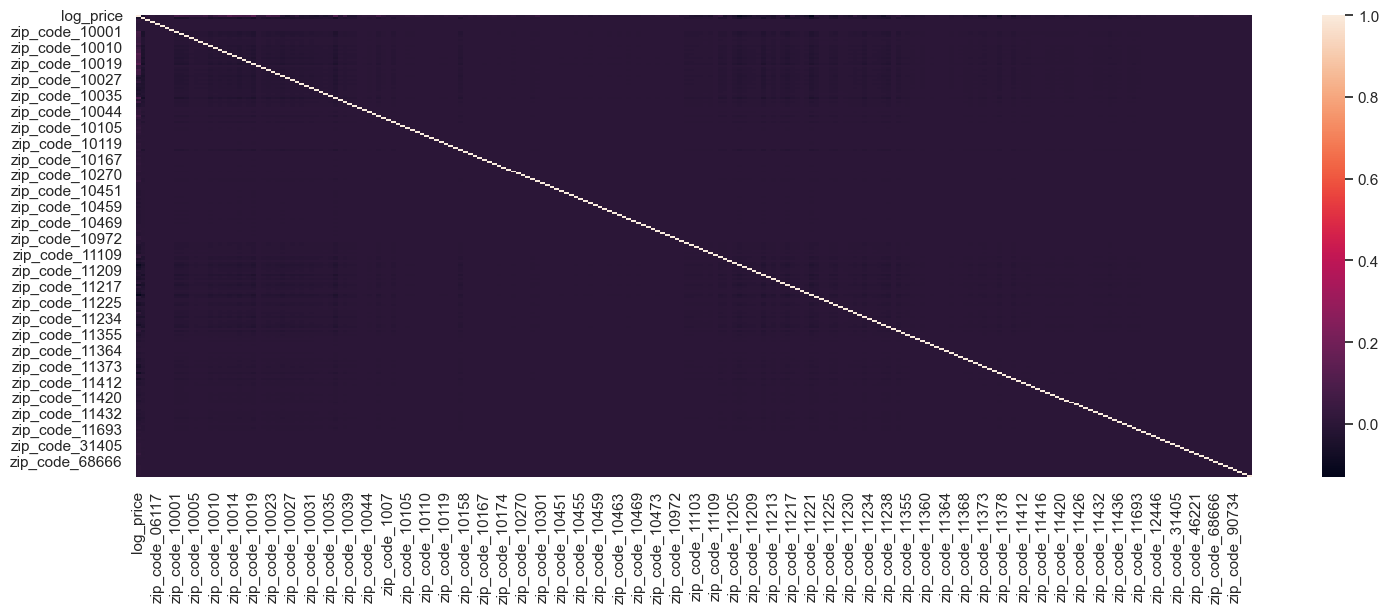

In [21]:
sns.heatmap(corr_df)